In [1]:
"""
Bayesian Neural Network
=======================

We demonstrate how to use NUTS to do inference on a simple (small)
Bayesian neural network with two hidden layers.
"""

import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

from jax import vmap
import jax.numpy as np
import jax.random as random
from jax.nn import elu, relu

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

matplotlib.use('Agg')  # noqa: E402


In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(1)

In [3]:


# the non-linearity we use in our neural network
def nonlin(x):
    #return np.tanh(x)
    return elu(x)


# a two-layer bayesian neural network with computational flow
# given by D_X => D_H => D_H => D_Y where D_H is the number of
# hidden units. (note we indicate tensor dimensions in the comments)
def model(X, Y, D_H):

    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(np.zeros((D_X, D_H)), np.ones((D_X, D_H))))  # D_X D_H
    z1 = nonlin(np.matmul(X, w1))   # N D_H  <= first layer of activations

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(np.zeros((D_H, D_H)), np.ones((D_H, D_H))))  # D_H D_H
    z2 = nonlin(np.matmul(z1, w2))  # N D_H  <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.Normal(np.zeros((D_H, D_Y)), np.ones((D_H, D_Y))))  # D_H D_Y
    z3 = np.matmul(z2, w3)  # N D_Y  <= output of the neural network

    # we put a prior on the observation noise
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / np.sqrt(prec_obs)

    # observe data
    return numpyro.sample("Y", dist.Normal(z3, sigma_obs), obs=Y)




In [4]:
# create artificial regression dataset
def get_data(N=50, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    onp.random.seed(0)
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, onp.newaxis], np.arange(D_X))
    W = 0.5 * onp.random.randn(D_X)
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * onp.random.randn(N)
    Y = Y[:, onp.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, onp.newaxis], np.arange(D_X))

    return X, Y, X_test

In [5]:


# helper function for HMC inference
def run_inference(model, args, rng_key, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args['num_warmup'], args['num_samples'], num_chains=args['num_chains'],
                progress_bar=True)
    mcmc.run(rng_key, X, Y, D_H)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace['Y']['value']




In [6]:
args = {'num_samples': 2000, 'num_chains': 1, 'num_warmup': 2000}
N, D_X, D_H = 20, 3, 25

def run_inference_and_compute_eigs(N, D_X=3, D_H=15):
    X, Y, X_test = get_data(N=N, D_X=D_X)

    # do inference
    rng_key, rng_key_predict = random.split(random.PRNGKey(0))
    samples = run_inference(model, args, rng_key, X, Y, D_H)
    
    # predict Y_test at inputs X_test
    vmap_args = (samples, random.split(rng_key_predict, args['num_samples'] * args['num_chains']))
#     test_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test, D_H))(*vmap_args)
#     test_predictions = test_predictions[..., 0]

    train_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X, D_H))(*vmap_args)
    train_predictions = train_predictions[..., 0]

    # compute mean prediction and confidence interval around median
    #mean_prediction = np.mean(test_predictions, axis=0)
    #percentiles = onp.percentile(test_predictions, [5.0, 95.0], axis=0)
    
    pars_list = []
    for keys in samples.keys():
        items = samples[keys]
        pars_list.append(items.reshape(args['num_samples'],-1))
    pars = np.hstack(pars_list)

    pars_eigs = np.linalg.svd(pars)[1]**2 / (args['num_samples']-1)
    
    function_eigs = np.linalg.svd(np.cov(train_predictions.T))[1]**2 / (args['num_samples'] - 1)
    
    return pars_eigs, function_eigs

In [7]:
n_list = [20, 100, 200, 500, 800, 1000, 1300, 1600, 1800, 2000, 2500, 3000]

In [8]:
all_eig_list = [run_inference_and_compute_eigs(n, D_H=15) for n in n_list]

sample: 100%|██████████| 4000/4000 [00:50<00:00, 79.20it/s, 511 steps of size 6.24e-03. acc. prob=0.92]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs      7.64      2.54      7.29      3.58     11.68   1573.06      1.00
   w1[0,0]     -0.00      0.99     -0.02     -1.64      1.62   1035.65      1.00
   w1[0,1]     -0.08      0.98     -0.06     -1.57      1.56   1139.79      1.00
   w1[0,2]     -0.07      1.01     -0.09     -1.71      1.53   1134.27      1.00
   w1[0,3]     -0.09      0.95     -0.12     -1.73      1.37   1022.94      1.00
   w1[0,4]     -0.01      1.01     -0.02     -1.66      1.61   1219.14      1.00
   w1[0,5]     -0.05      1.02     -0.02     -1.63      1.67   1038.89      1.00
   w1[0,6]     -0.09      1.03     -0.09     -1.96      1.42   1176.36      1.00
   w1[0,7]     -0.05      0.99     -0.06     -1.68      1.57    830.86      1.00
   w1[0,8]     -0.04      0.99     -0.02     -1.58      1.60   1251.70      1.00
   w1[0,9]     -0.08      0.99     -0.09     -1.70      1.49   1028.90      1.00
  w1[0,10]     -0.05      0

sample: 100%|██████████| 4000/4000 [01:57<00:00, 34.04it/s, 1023 steps of size 1.96e-03. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     18.59      2.66     18.46     14.04     22.59    760.12      1.01
   w1[0,0]     -0.11      0.98     -0.11     -1.58      1.60    410.62      1.01
   w1[0,1]     -0.07      1.00     -0.02     -1.71      1.56    368.67      1.00
   w1[0,2]     -0.06      0.94     -0.07     -1.54      1.54    443.91      1.00
   w1[0,3]     -0.13      0.96     -0.14     -1.72      1.40    406.28      1.00
   w1[0,4]     -0.11      1.01     -0.12     -1.83      1.50    404.13      1.00
   w1[0,5]     -0.05      0.96     -0.07     -1.47      1.76    430.59      1.00
   w1[0,6]     -0.13      0.96     -0.13     -1.66      1.49    422.75      1.00
   w1[0,7]     -0.04      1.00     -0.01     -1.83      1.48    359.62      1.00
   w1[0,8]     -0.13      0.97     -0.11     -1.70      1.41    370.62      1.00
   w1[0,9]     -0.09      0.96     -0.07     -1.71      1.38    483.54      1.00
  w1[0,10]     -0.09      0

sample: 100%|██████████| 4000/4000 [02:44<00:00, 24.29it/s, 1023 steps of size 1.75e-03. acc. prob=0.81]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     21.86      2.18     21.79     18.12     25.04    515.88      1.01
   w1[0,0]     -0.07      0.97     -0.06     -1.55      1.61    305.42      1.00
   w1[0,1]      0.02      1.01      0.01     -1.62      1.64    295.12      1.00
   w1[0,2]     -0.06      0.93     -0.08     -1.51      1.56    336.31      1.00
   w1[0,3]     -0.13      1.02     -0.12     -1.98      1.34    219.24      1.00
   w1[0,4]      0.01      0.99      0.03     -1.60      1.68    280.46      1.00
   w1[0,5]     -0.05      1.01     -0.08     -1.70      1.61    225.27      1.01
   w1[0,6]     -0.09      0.99     -0.12     -1.75      1.45    322.48      1.00
   w1[0,7]     -0.12      0.98     -0.06     -1.69      1.45    201.32      1.00
   w1[0,8]     -0.01      1.02      0.02     -1.63      1.67    205.94      1.00
   w1[0,9]     -0.12      0.98     -0.15     -1.85      1.33    242.09      1.00
  w1[0,10]     -0.08      1

sample: 100%|██████████| 4000/4000 [05:25<00:00, 12.30it/s, 1023 steps of size 7.81e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.83      1.55     24.82     22.34     27.35     98.46      1.05
   w1[0,0]     -0.11      0.92     -0.00     -1.69      1.28     57.19      1.02
   w1[0,1]      0.00      0.97      0.03     -1.68      1.52     39.41      1.01
   w1[0,2]      0.00      0.88     -0.01     -1.43      1.41     62.09      1.01
   w1[0,3]     -0.13      0.98     -0.15     -1.84      1.33     75.17      1.00
   w1[0,4]     -0.15      0.86     -0.16     -1.63      1.22     28.47      1.03
   w1[0,5]     -0.03      0.90      0.01     -1.42      1.47     74.65      1.02
   w1[0,6]     -0.14      0.98     -0.19     -1.68      1.49     87.01      1.03
   w1[0,7]     -0.08      0.99     -0.12     -1.58      1.69     36.10      1.00
   w1[0,8]     -0.11      1.07     -0.14     -1.96      1.52     51.22      1.00
   w1[0,9]     -0.03      1.06      0.01     -1.70      1.72     64.26      1.00
  w1[0,10]     -0.10      0

sample: 100%|██████████| 4000/4000 [08:00<00:00,  8.33it/s, 1023 steps of size 6.67e-04. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.45      1.26     25.41     23.50     27.68     60.34      1.09
   w1[0,0]     -0.19      0.98     -0.10     -1.76      1.35     31.92      1.15
   w1[0,1]     -0.23      0.98     -0.16     -1.83      1.43     27.42      1.00
   w1[0,2]      0.02      0.92      0.04     -1.39      1.66     44.91      1.00
   w1[0,3]     -0.39      0.98     -0.41     -1.92      1.28     26.07      1.00
   w1[0,4]      0.02      1.03      0.01     -1.71      1.72     26.23      1.06
   w1[0,5]      0.13      0.87      0.14     -1.28      1.50     56.24      1.01
   w1[0,6]     -0.16      1.01     -0.15     -1.81      1.42     41.86      1.06
   w1[0,7]      0.08      0.99      0.08     -1.48      1.78     32.74      1.00
   w1[0,8]     -0.02      1.05      0.01     -1.95      1.55     38.05      1.01
   w1[0,9]      0.06      0.99      0.00     -1.37      1.79     48.50      1.02
  w1[0,10]     -0.11      0

sample: 100%|██████████| 4000/4000 [09:56<00:00,  6.70it/s, 1023 steps of size 4.82e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     26.59      1.20     26.64     24.55     28.59     27.23      1.17
   w1[0,0]     -0.27      0.95     -0.21     -1.83      1.29     39.67      1.00
   w1[0,1]     -0.10      1.09      0.06     -1.69      1.80     12.86      1.02
   w1[0,2]      0.02      0.77      0.16     -1.40      1.11     39.80      1.00
   w1[0,3]     -0.38      0.96     -0.37     -2.03      0.99     22.27      1.03
   w1[0,4]     -0.19      0.85     -0.26     -1.55      1.24     14.32      1.00
   w1[0,5]     -0.15      0.79     -0.16     -1.50      1.12     42.83      1.00
   w1[0,6]     -0.34      0.93     -0.38     -1.86      1.20     39.25      1.00
   w1[0,7]      0.24      1.06      0.23     -1.37      1.99     11.73      1.13
   w1[0,8]     -0.36      0.98     -0.55     -1.78      1.28     22.74      1.24
   w1[0,9]     -0.12      1.00     -0.17     -1.72      1.42     25.51      1.04
  w1[0,10]     -0.35      0

sample: 100%|██████████| 4000/4000 [11:37<00:00,  5.73it/s, 1023 steps of size 6.72e-04. acc. prob=0.78]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.59      1.07     27.58     26.03     29.59     61.99      1.07
   w1[0,0]     -0.16      0.83     -0.16     -1.34      1.30     67.31      1.02
   w1[0,1]     -0.12      0.93     -0.00     -1.63      1.18     23.31      1.06
   w1[0,2]      0.39      0.72      0.41     -0.74      1.52     19.20      1.10
   w1[0,3]     -0.32      0.90     -0.25     -1.77      1.13     59.40      1.00
   w1[0,4]     -0.16      0.99     -0.11     -1.68      1.48     25.84      1.06
   w1[0,5]      0.00      0.93     -0.01     -1.52      1.44     74.21      1.10
   w1[0,6]     -0.40      0.94     -0.41     -1.82      1.16     49.65      1.00
   w1[0,7]      0.25      0.90      0.24     -1.20      1.79     19.88      1.01
   w1[0,8]     -0.12      0.96     -0.15     -1.69      1.44     37.63      1.04
   w1[0,9]     -0.05      0.99     -0.11     -1.87      1.54     30.21      1.01
  w1[0,10]     -0.14      0

sample: 100%|██████████| 4000/4000 [14:07<00:00,  4.72it/s, 1023 steps of size 4.55e-04. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.54      0.94     27.55     26.00     29.07     39.19      1.12
   w1[0,0]     -0.53      0.89     -0.49     -1.76      0.96      7.90      1.32
   w1[0,1]     -0.15      1.03     -0.04     -1.68      1.65     16.12      1.02
   w1[0,2]      0.19      0.88      0.12     -1.10      1.92     17.90      1.01
   w1[0,3]     -0.56      0.89     -0.62     -1.93      0.82     26.82      1.01
   w1[0,4]     -0.07      0.86     -0.10     -1.26      1.49     11.10      1.08
   w1[0,5]     -0.09      0.80     -0.05     -1.43      1.10     39.50      1.03
   w1[0,6]     -0.42      0.95     -0.45     -2.22      1.04     18.19      1.00
   w1[0,7]      0.04      0.83      0.05     -1.25      1.44     16.07      1.02
   w1[0,8]     -0.20      1.02     -0.25     -1.73      1.59     37.16      1.01
   w1[0,9]     -0.12      0.88     -0.04     -1.61      1.26     16.65      1.14
  w1[0,10]     -0.47      0

sample: 100%|██████████| 4000/4000 [17:01<00:00,  3.92it/s, 1023 steps of size 4.07e-04. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.27      0.88     27.31     25.94     28.86     26.15      1.16
   w1[0,0]     -0.27      0.74     -0.11     -1.49      0.84     24.02      1.09
   w1[0,1]     -0.13      0.97      0.05     -1.91      1.16     12.99      1.07
   w1[0,2]      0.02      0.84     -0.06     -1.17      1.56     19.76      1.00
   w1[0,3]     -0.52      0.85     -0.52     -2.02      0.73     14.12      1.33
   w1[0,4]     -0.07      1.00     -0.18     -1.88      1.42      9.60      1.15
   w1[0,5]      0.15      0.72      0.18     -1.04      1.32     41.54      1.04
   w1[0,6]     -0.36      0.94     -0.42     -2.02      0.89     13.32      1.00
   w1[0,7]      0.02      0.92     -0.03     -1.36      1.64     21.48      1.00
   w1[0,8]     -0.31      0.94     -0.32     -1.75      1.41     16.89      1.03
   w1[0,9]      0.08      0.79      0.15     -1.47      1.27     11.32      1.31
  w1[0,10]     -0.17      0

sample: 100%|██████████| 4000/4000 [17:54<00:00,  3.72it/s, 1023 steps of size 3.62e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.50      0.88     27.58     26.07     29.03     19.61      1.24
   w1[0,0]     -0.72      0.77     -0.73     -1.88      0.62      6.06      1.36
   w1[0,1]     -0.08      1.05     -0.03     -1.88      1.43     14.43      1.00
   w1[0,2]     -0.01      0.91     -0.07     -1.48      1.53     11.65      1.02
   w1[0,3]     -0.57      0.87     -0.49     -2.37      0.56     16.97      1.13
   w1[0,4]      0.03      1.00     -0.10     -1.58      1.68      6.17      1.24
   w1[0,5]      0.11      0.80      0.14     -1.36      1.23     12.07      1.02
   w1[0,6]     -0.43      0.79     -0.45     -1.84      0.82     20.08      1.03
   w1[0,7]      0.12      1.02      0.13     -1.51      1.87     11.12      1.00
   w1[0,8]     -0.44      0.87     -0.50     -1.71      1.15     21.82      1.12
   w1[0,9]     -0.48      0.80     -0.42     -1.68      0.79     23.96      1.02
  w1[0,10]     -0.45      0

sample: 100%|██████████| 4000/4000 [22:30<00:00,  2.96it/s, 1023 steps of size 3.35e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.43      0.76     27.50     26.21     28.77     22.00      1.22
   w1[0,0]     -0.32      0.76     -0.23     -1.63      0.70      9.31      1.36
   w1[0,1]     -0.32      1.03     -0.22     -2.11      1.24     11.01      1.01
   w1[0,2]     -0.10      0.64     -0.18     -1.11      0.97     20.08      1.02
   w1[0,3]     -0.46      1.00     -0.33     -2.34      0.91      8.85      1.15
   w1[0,4]     -0.01      1.29     -0.10     -1.99      1.98      6.00      1.02
   w1[0,5]     -0.06      0.76     -0.05     -1.29      1.27     23.21      1.00
   w1[0,6]     -0.52      0.97     -0.42     -2.12      1.13      8.56      1.03
   w1[0,7]      0.28      1.02      0.29     -1.10      2.37      8.09      1.03
   w1[0,8]     -0.11      0.66     -0.05     -1.23      0.87      9.64      1.52
   w1[0,9]     -0.05      0.95      0.15     -1.60      1.47      8.98      1.36
  w1[0,10]      0.16      0

sample: 100%|██████████| 4000/4000 [25:09<00:00,  2.65it/s, 1023 steps of size 3.68e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.78      0.73     27.85     26.62     29.08     22.57      1.19
   w1[0,0]     -0.19      1.01     -0.00     -1.79      1.28      3.46      2.05
   w1[0,1]     -0.13      1.01     -0.17     -1.80      1.79     12.98      1.11
   w1[0,2]      0.21      0.70      0.22     -1.09      1.25     13.61      1.04
   w1[0,3]     -0.30      0.63     -0.23     -1.38      0.72     29.99      1.00
   w1[0,4]     -0.05      0.85      0.02     -1.34      1.38     10.87      1.07
   w1[0,5]      0.06      0.51      0.09     -0.87      0.81     16.09      1.01
   w1[0,6]     -0.70      0.90     -0.74     -2.20      0.77     14.87      1.01
   w1[0,7]      0.26      1.10      0.26     -1.35      2.09     12.96      1.00
   w1[0,8]     -0.19      0.92     -0.09     -1.62      1.31     14.14      1.05
   w1[0,9]     -0.12      0.93     -0.08     -1.69      1.39     14.44      1.11
  w1[0,10]     -0.23      1

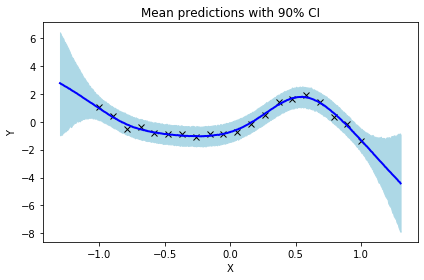

In [42]:


# # make plots
# fig, ax = plt.subplots(1, 1)

# # plot training data
# ax.plot(X[:, 1], Y[:, 0], 'kx')
# # plot 90% confidence level of predictions
# ax.fill_between(X_test[:, 1], percentiles[0, :], percentiles[1, :], color='lightblue')
# # plot mean prediction
# ax.plot(X_test[:, 1], mean_prediction, 'blue', ls='solid', lw=2.0)
# ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")
# plt.tight_layout()



Text(0.5, 1.0, 'Parameter Space Eigenvalues')

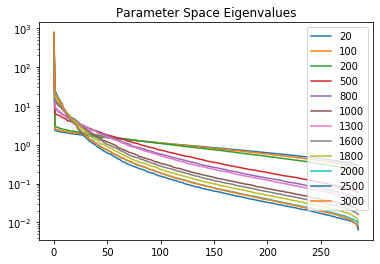

In [9]:
[plt.semilogy(all_eig_list[xx][0], label = str(n_list[xx])) for xx in range(len(n_list))]
plt.legend()
plt.title('Parameter Space Eigenvalues')

Text(0.5, 1.0, 'Function Space Eigenvalues')

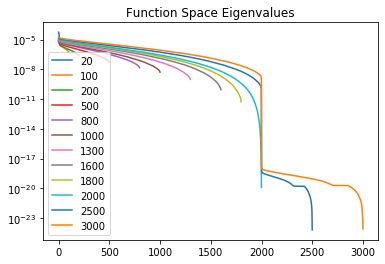

In [10]:
[plt.semilogy(all_eig_list[xx][1], label = str(n_list[xx])) for xx in range(len(n_list))]
plt.legend()
plt.title('Function Space Eigenvalues')

In [11]:
def eff_dim(x, s = 1.):
    return np.sum(x / (x + s))

In [22]:
eff_dims_parameters = [eff_dim(all_eig_list[x][0]) for x in range(len(n_list))]
eff_dims_fns = [eff_dim(all_eig_list[x][1], s=1e-4) for x in range(len(n_list))]


(0, 140)

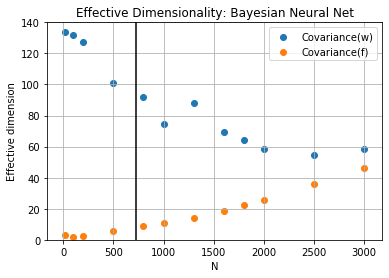

In [27]:
plt.scatter(n_list, eff_dims_parameters, label = 'Covariance(w)')
plt.scatter(n_list, eff_dims_fns, label = 'Covariance(f)')
plt.legend()
plt.ylabel('Effective dimension')
plt.xlabel('N')
plt.grid()
plt.title('Effective Dimensionality: Bayesian Neural Net')
plt.vlines(726, -10, 160)
plt.ylim((0, 140))
#plt.scatter([20, 200, 2000], eff_dims_fns)

In [28]:
import pickle

In [31]:
with open('../../saved-experiments/bnn_regression_evals.pkl', 'wb') as handle:
    pickle.dump(all_eig_list, handle)